# 1. load the data

In [46]:
import os
import random

import cv2
import mediapipe as mp
import numpy as np
import tqdm
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from scripts.feature_extraction.mediapiple import get_mediapipe_preds

In [47]:
data_root_dir = '../../data/data/dataset1'


def load_image_paths_and_labels(data_root_dir):
    # return the images' path
    X = []
    X_extracted_feature = []
    y = []

    def append_path(dir, label):
        for f in os.listdir(dir):
            sub_path = os.path.join(dir, f)
            if not os.path.isdir(sub_path):
                # might be a file
                if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png'):
                    X.append(sub_path)
                    y.append(label)
                if f.endswith('.npy'):
                    X_extracted_feature.append(np.load(sub_path, allow_pickle=True))
            else:
                # nested folder
                append_path(sub_path, label)

    for label in os.listdir(data_root_dir):
        label_path = os.path.join(data_root_dir, label)
        if not os.path.isdir(label_path):
            continue

        # nested folder
        append_path(label_path, label)
    return X, X_extracted_feature, y


X, X_extracted_feature, y = load_image_paths_and_labels(data_root_dir)

In [48]:
X.__len__()

9817

In [49]:
y.__len__()

9817

# 2. load the images RGB data, also extract the csv files with hand gesture estimator

In [50]:
for hands_path in tqdm.tqdm(X):
    if os.path.basename(hands_path) + '.npy' in os.listdir(os.path.dirname(hands_path)):
        continue
    hands = get_mediapipe_preds(hands_path)
    if not hands:
        continue
    X_extracted_feature.append(hands)
    np.save(f'{hands_path}.npy', hands)

100%|██████████| 9817/9817 [00:11<00:00, 882.70it/s] 


In [51]:
shapes = [arr.shape for arr in X_extracted_feature]
unique_shapes = set(shapes)
print("Unique shapes:", unique_shapes)
count = 0
c = 0
for i in X_extracted_feature:
    if i.shape == (21, 2):
        count += 1
    else:
        c += 1
print(count, c)

Unique shapes: {(21, 2)}
9817 0


In [52]:
X_extracted_feature = np.array(X_extracted_feature)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_extracted_feature, y, test_size=0.2, random_state=42)

# 3. train a classifier
## 3.1 random forest

In [53]:
random_forest_clf = RandomForestClassifier(n_estimators=100)
X_train_flattened = X_train.reshape((X_train.shape[0], -1))
random_forest_clf.fit(X_train_flattened, y_train)

RandomForestClassifier()

In [54]:
X_test_flattened = X_test.reshape((X_test.shape[0], -1))
y_pred = random_forest_clf.predict(X_test_flattened)

print('Classification report for classifier %s:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Classification report for classifier %s:
               precision    recall  f1-score   support

    gesture1       1.00      0.99      1.00       393
    gesture2       0.99      1.00      1.00       334
    gesture3       0.99      1.00      1.00       352
    gesture4       1.00      1.00      1.00        41
    gesture5       1.00      1.00      1.00        53
    gesture6       1.00      1.00      1.00       382
    gesture7       1.00      1.00      1.00        94
    gesture8       1.00      1.00      1.00       315

    accuracy                           1.00      1964
   macro avg       1.00      1.00      1.00      1964
weighted avg       1.00      1.00      1.00      1964

Confusion matrix:
 [[391   1   1   0   0   0   0   0]
 [  0 333   1   0   0   0   0   0]
 [  0   1 351   0   0   0   0   0]
 [  0   0   0  41   0   0   0   0]
 [  0   0   0   0  53   0   0   0]
 [  0   0   0   0   0 382   0   0]
 [  0   0   0   0   0   0  94   0]
 [  0   0   0   0   0   0   0 315]]


# visualize a random one of them

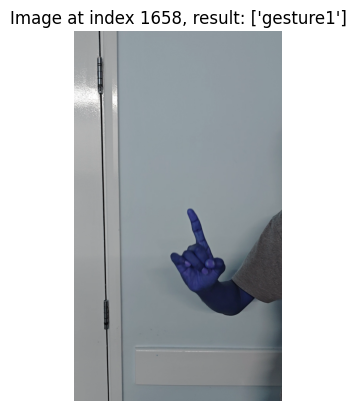

In [57]:
def random_visualize():
    # Randomly pick one index
    idx = random.randint(0, len(X) - 1)
    img = cv2.imread(X[idx])

    features = np.array([np.load(X[idx] + '.npy')])
    input_feature = features.reshape((features.shape[0], -1))
    res = random_forest_clf.predict(input_feature)

    plt.imshow(img)
    plt.title(f"Image at index {idx}, result: {res}")
    plt.axis('off')
    plt.show()


random_visualize()